In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import numpy as np
import math
from datetime import datetime,timezone

from scipy import stats



In [3]:
# import functions_framework
# @functions_framework.http
# def demo_load_v2_new_incident_ml_to_bq(request):

isTrainData=False
isExploreMode=False

In [4]:
dt_imported=datetime.now(timezone.utc)

str_imported=dt_imported.strftime('%Y-%m-%d %H:%M:%S')
print(f"Imported DateTime: {str_imported}" )

# explore min and max import data
imported_to='2023-07-16'

Imported DateTime: 2023-08-12 06:17:19


In [5]:
schema_for_new_data=None
threshold_x_sd = 3  # 2x-4x
split_test=0.2

# Bigquery configuration setting

In [6]:
projectId='pongthorn'
client = bigquery.Client(project=projectId)

dw_dataset_id="SMartDW"
dataset_id="SMartML"

dw_table_id = f"{projectId}.{dw_dataset_id}.incident"

In [7]:
def load_data_bq(sql:str):

 query_result=client.query(sql)
 df_all=query_result.to_dataframe()
 return df_all

def loadDataFrameToBQ(table_id,dfx):
    try:
        if isTrainData:
            job_config = bigquery.LoadJobConfig(
                write_disposition="WRITE_TRUNCATE",
            )
        else:
                   job_config = bigquery.LoadJobConfig(
                write_disposition="WRITE_APPEND",schema=schema_for_new_data
            )

        job = client.load_table_from_dataframe(
            dfx, table_id, job_config=job_config
        )
        job.result()  # Wait for the job to complete.
        print(f"TrainData={isTrainData} : {len(dfx)} rows imported to {table_id} successfully")

    except BadRequest as e:
        print("Bigquery Error\n")
        for e in job.errors:
            print('ERROR: {}'.format(e['message']))

In [8]:
label='severity_id'
labelName='severity_name'

dateCols=['open_datetime','close_datetime']
numbericCols=['open_to_close_hour']
start_end_list=[ ['open_datetime','close_datetime']]

cateCols=['sla','product_type','brand','service_type','incident_type']

# Create New Data Table

In [9]:
def get_table_schema(table_ml_id):
    schema=[]
    try:
        table=client.get_table(table_ml_id)  # Make an API request.
        schema=table.schema
        print("Table {} already exists.".format(table_ml_id))
    except Exception as ex:
        schema = [
        bigquery.SchemaField("id", "INTEGER", mode="REQUIRED"),
        bigquery.SchemaField("severity_id", "INTEGER", mode="REQUIRED"),
        bigquery.SchemaField("severity_name", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("sla", "STRING", mode="REQUIRED"),    
        bigquery.SchemaField("product_type", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("brand", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("service_type", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("incident_type", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("open_to_close_hour", "FLOAT", mode="REQUIRED"),   
        bigquery.SchemaField("imported_at", "DATETIME", mode="REQUIRED")    
        ]

        table = bigquery.Table(table_ml_id,schema=schema)
        table.time_partitioning = bigquery.TimePartitioning(
        type_=bigquery.TimePartitioningType.DAY,field="imported_at")


        table = client.create_table(table)  # Make an API request.
        print(
            "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
        )
    finally:
       print(f"Get Schema of {table_ml_id} as below.")    
       return schema
        

# Get Max Import Data From New Data

In [10]:
def get_last_imported_at(table_ml_id):

    sql_lastImport=f"SELECT max(imported_at) as last_imported from `{table_ml_id}` "

    print(sql_lastImport)

    job_lastImported=client.query(sql_lastImport)
    str_lastImported=None
    for row in job_lastImported:    
        if row.last_imported is not None: 
            str_lastImported=row.last_imported.strftime('%Y-%m-%d %H:%M:%S')
    print(f"Last Imported DateTime: {str_lastImported}" )

    if str_lastImported is not None:
      print("Start date from last loading")  
      start_date_query=str_lastImported
    else:
      start_date_query=imported_to  
      print("Init First loading") 
    return start_date_query    
    

# Retrieve data from BigQuery

In [11]:

sql_all=f"""
SELECT  id,severity_id,severity_name
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime
,updated_at,imported_at
FROM `{dw_table_id}` """

if isTrainData: # get from imported_to specified by you
    print(f"Build train/test data during imported date < {datetime.strptime(imported_to,'%Y-%m-%d')}")

    train_name='train2_incident'
    test_name='test2_incident'
    train_table_id=f"{projectId}.{dataset_id}.{train_name}"
    test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
    print(f"TrainTable2={train_table_id} and TestTable2={test_tabel_id}")
    
    sql_all=f""" {sql_all}
    WHERE imported_at< '{imported_to}'
    order by imported_at desc
    
    """
    
else: # get from max update
    new_incident_name='new2_incident'    
    new_incident_table_id=f"{projectId}.{dataset_id}.{new_incident_name}"
    print(f"{new_incident_table_id}")
    
    # 1.get table and its schema
    schema_for_new_data=get_table_schema(new_incident_table_id)
    # print(schema_for_new_data)
    imported_to=get_last_imported_at(new_incident_table_id)  # get  start_date_query  from this method
    print(f"Load the most up-to-date new data from imported date >= {imported_to}")
    print(imported_to)
    
    
    sql_all=f""" {sql_all}
    WHERE imported_at>= '{imported_to}'
    order by imported_at desc
    
    """

print(sql_all)

pongthorn.SMartML.new2_incident
Table pongthorn.SMartML.new2_incident already exists.
Get Schema of pongthorn.SMartML.new2_incident as below.
SELECT max(imported_at) as last_imported from `pongthorn.SMartML.new2_incident` 
Last Imported DateTime: 2023-08-08 16:39:37
Start date from last loading
Load the most up-to-date new data from imported date >= 2023-08-08 16:39:37
2023-08-08 16:39:37
 
SELECT  id,severity_id,severity_name
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime
,updated_at,imported_at
FROM `pongthorn.SMartDW.incident` 
    WHERE imported_at>= '2023-08-08 16:39:37'
    order by imported_at desc
    
    


In [15]:
print("Load data from Bigquery")
df_all=load_data_bq(sql_all)
no_original_rows=len(df_all)

if no_original_rows==0:
 print("No records from bigquery")  
 quit()
 # return "No new data imported to bigquery"   
else:
 df_all=df_all.drop_duplicates(subset=['id'],keep='last')   
 print(f"Import at :{df_all['imported_at'].min()} - {df_all['imported_at'].max()}")   
 print(df_all.shape)  
print(df_all.info())
print(df_all[["severity_id","severity_name","updated_at","imported_at"]].head())

Load data from Bigquery
Import at :2023-08-08 17:05:07.708544 - 2023-08-11 17:05:07.354067
(33, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 0 to 36
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              33 non-null     Int64         
 1   severity_id     33 non-null     Int64         
 2   severity_name   33 non-null     object        
 3   sla             33 non-null     object        
 4   product_type    33 non-null     object        
 5   brand           33 non-null     object        
 6   service_type    33 non-null     object        
 7   incident_type   33 non-null     object        
 8   open_datetime   33 non-null     datetime64[ns]
 9   close_datetime  33 non-null     datetime64[ns]
 10  updated_at      33 non-null     datetime64[ns]
 11  imported_at     33 non-null     datetime64[ns]
dtypes: Int64(2), datetime64[ns](4), object(6)
memory usage: 3.4+ KB


# Remove incorrect data

In [16]:
print(f"Open Date : {df_all['open_datetime'].min()} - {df_all['open_datetime'].max()}")   
print(f"Close Date : {df_all['close_datetime'].min()} - {df_all['close_datetime'].max()}")
# df_all=df_all.query("close_datetime<'2023-08-01'")
df_all.info()

Open Date : 2023-06-09 15:06:00 - 2023-08-10 10:03:00
Close Date : 2023-07-01 20:12:00 - 2023-08-10 11:44:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 0 to 36
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              33 non-null     Int64         
 1   severity_id     33 non-null     Int64         
 2   severity_name   33 non-null     object        
 3   sla             33 non-null     object        
 4   product_type    33 non-null     object        
 5   brand           33 non-null     object        
 6   service_type    33 non-null     object        
 7   incident_type   33 non-null     object        
 8   open_datetime   33 non-null     datetime64[ns]
 9   close_datetime  33 non-null     datetime64[ns]
 10  updated_at      33 non-null     datetime64[ns]
 11  imported_at     33 non-null     datetime64[ns]
dtypes: Int64(2), datetime64[ns](4), object(6)
memory usage:

In [14]:
df_all.tail()

,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_datetime,close_datetime,updated_at,imported_at
99,3173,4,Cosmetic,24x7 4Hrs Resolution Time,Software,Veeam,Request,Software,2023-07-12 10:00:00,2023-07-12 12:00:00,2023-07-17 11:36:13,2023-07-19 17:30:20.092791
100,3192,4,Cosmetic,24x7 4Hrs Resolution Time,Software,Veeam,Request,Software,2023-07-11 09:00:00,2023-07-11 13:00:00,2023-07-18 14:40:50,2023-07-19 17:30:20.092791
101,3190,4,Cosmetic,24x7 4Hrs Resolution Time,Software,VMWare,Request,Upgrade Software,2023-07-17 14:00:00,2023-07-17 16:00:00,2023-07-18 12:27:14,2023-07-19 17:30:20.092791
102,3191,4,Cosmetic,24x7 4Hrs Resolution Time,Software,VMWare,Request,Upgrade Software,2023-07-17 01:00:00,2023-07-17 15:30:00,2023-07-18 12:29:30,2023-07-19 17:30:20.092791
103,3189,4,Cosmetic,24x7 4Hrs Resolution Time,Software,VMWare,Request,Upgrade Software,2023-07-17 09:00:00,2023-07-17 11:30:00,2023-07-18 12:23:26,2023-07-19 17:30:20.092791


# Create addtional feature : Service Interval (CloseDateTime-OpenDateTime)

In [15]:
# (0, 24] =by 1 day
# (24, 168] = 1day -1 week
# (168, 360]= 1week- 15 days(half a month) 
# (360, 720]= 15 dasy-1 month
# (720, 2349]=1 month-1 Q 

In [16]:
print("Manage Numberic Cols")
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan)
                                              


#print(df_all[listDiffHourCols].describe())

# https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  

df_all.tail()

Manage Numberic Cols
       open_to_close_hour
count          100.000000
mean           181.877667
std            552.875536
min              0.683333
25%              2.833333
50%              7.916667
75%             80.945833
max           3534.200000


,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_datetime,close_datetime,updated_at,imported_at,open_to_close,open_to_close_hour,zscore_open_to_close_hour
99,3173,4,Cosmetic,24x7 4Hrs Resolution Time,Software,Veeam,Request,Software,2023-07-12 10:00:00,2023-07-12 12:00:00,2023-07-17 11:36:13,2023-07-19 17:30:20.092791,0 days 02:00:00,2.0,0.326988
100,3192,4,Cosmetic,24x7 4Hrs Resolution Time,Software,Veeam,Request,Software,2023-07-11 09:00:00,2023-07-11 13:00:00,2023-07-18 14:40:50,2023-07-19 17:30:20.092791,0 days 04:00:00,4.0,0.323353
101,3190,4,Cosmetic,24x7 4Hrs Resolution Time,Software,VMWare,Request,Upgrade Software,2023-07-17 14:00:00,2023-07-17 16:00:00,2023-07-18 12:27:14,2023-07-19 17:30:20.092791,0 days 02:00:00,2.0,0.326988
102,3191,4,Cosmetic,24x7 4Hrs Resolution Time,Software,VMWare,Request,Upgrade Software,2023-07-17 01:00:00,2023-07-17 15:30:00,2023-07-18 12:29:30,2023-07-19 17:30:20.092791,0 days 14:30:00,14.5,0.304265
103,3189,4,Cosmetic,24x7 4Hrs Resolution Time,Software,VMWare,Request,Upgrade Software,2023-07-17 09:00:00,2023-07-17 11:30:00,2023-07-18 12:23:26,2023-07-19 17:30:20.092791,0 days 02:30:00,2.5,0.326079


# Remove oulier and delete zero hour training data

In [17]:
if isTrainData :
    print("Remove oulier  and delete zero hour training data")
    for col in  xScoreDiffHourCols:
      df_all=df_all.query(f"{col}<@threshold_x_sd")


    allRows=df_all.shape[0]
    for col in numbericCols:
        zeroRows=len(df_all.query(f"{col}==0"))
        pctZeroHour=round(zeroRows/allRows*100,1)
        print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")
        df_all=df_all.query(f'{col}!=0')

# Final Tranalsform

In [18]:
removeCols=['updated_at','imported_at']
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols
print(f"Remove {removeCols}")

df_all=df_all.drop(columns=removeCols)
no_rows_after_removing_outlier=len(df_all)
pct_row_decrease=round( (no_original_rows-no_rows_after_removing_outlier)/no_original_rows*100 ,0)

print(f"% remove data {pct_row_decrease}")

df_all[['id','severity_id']] =df_all[['id','severity_id']].astype('int64')

if isTrainData==False:
    df_all['imported_at']=dt_imported

print(df_all.info())


print(f"pct removed data ={(no_original_rows-len(df_all))/no_original_rows*100}")
#it is pretty close to 5%   , at most 10% is removable
# df_all[listDiffHourCols].describe(percentiles=[.95,.75,.50,.25,.05]).drop(index=['count','std'])

df_all.tail(30)

Remove ['updated_at', 'imported_at', 'open_datetime', 'close_datetime', 'zscore_open_to_close_hour', 'open_to_close']
% remove data 4.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 103
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id                  100 non-null    int64              
 1   severity_id         100 non-null    int64              
 2   severity_name       100 non-null    object             
 3   sla                 100 non-null    object             
 4   product_type        100 non-null    object             
 5   brand               100 non-null    object             
 6   service_type        100 non-null    object             
 7   incident_type       100 non-null    object             
 8   open_to_close_hour  100 non-null    float64            
 9   imported_at         100 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC]

,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,imported_at
74,3182,2,Major,24x7 4Hrs Resolution Time,Storage,HPE,Incident,Hard Disk Drive Failure,6.233333,2023-08-08 16:39:37.692706+00:00
75,3168,2,Major,24x7 4Hrs Response Time,Firewall,Palo Alto,Incident,Controller/Node Failure,13.350000,2023-08-08 16:39:37.692706+00:00
76,3139,2,Major,24x7 4Hrs Resolution Time,Server,HPE,Incident,Hard Disk Drive Failure,6.333333,2023-08-08 16:39:37.692706+00:00
77,3131,2,Major,24x7 4Hrs Resolution Time,Server,HPE,Incident,Battery Failure,85.283333,2023-08-08 16:39:37.692706+00:00
78,3195,2,Major,24x7 6Hrs Resolution Time,Software,YIP,Incident,General Incident,230.000000,2023-08-08 16:39:37.692706+00:00
79,3125,2,Major,9x5 NBD 4Hrs Response Time,Server,HPE,Incident,OS / Firmware,161.500000,2023-08-08 16:39:37.692706+00:00
80,3176,2,Major,24x7 4Hrs Resolution Time,Software,Veeam,Incident,Software,7.833333,2023-08-08 16:39:37.692706+00:00
81,3178,2,Major,24x7 4Hrs Resolution Time,Software,VMWare,Incident,Software,1.616667,2023-08-08 16:39:37.692706+00:00
82,3187,3,Minor,24x7 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,23.400000,2023-08-08 16:39:37.692706+00:00
83,3188,3,Minor,24x7 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,54.983333,2023-08-08 16:39:37.692706+00:00


# Plot Numeric and Category columns

Plot Numeric  and Category columns


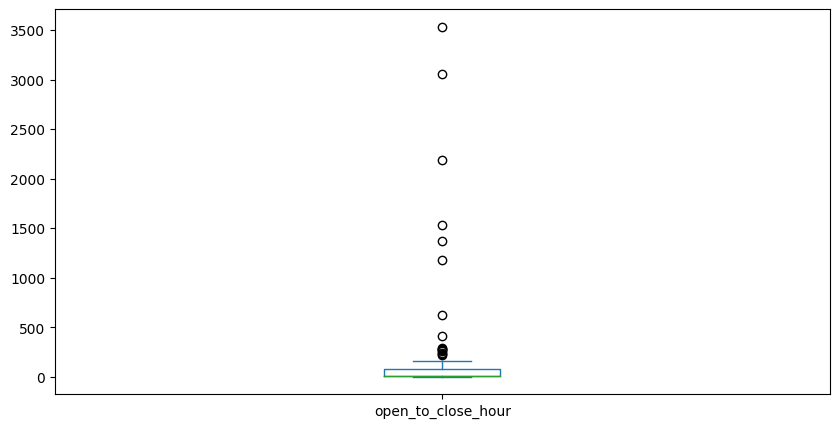

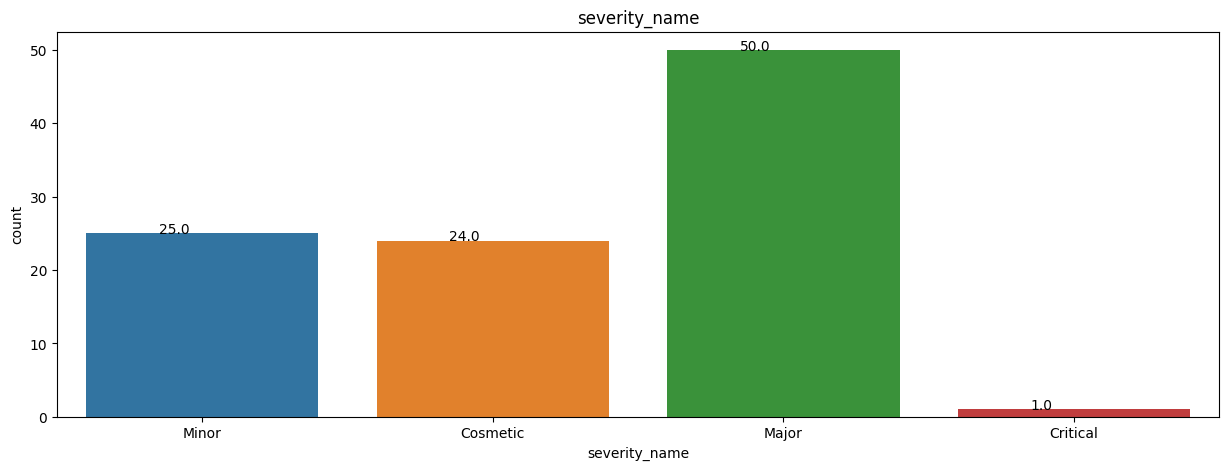

In [19]:
# comment on google cloud
if isExploreMode:
    print("Plot Numeric  and Category columns")
    import seaborn as sns
    import matplotlib.pyplot  as plt

if isExploreMode:
    df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
    plt.show()
    
if isExploreMode:
    barCols=["severity_name"]
    for col in barCols:
        fig , ax = plt.subplots(figsize=(15,5))
        ax =sns.countplot(x=col, data=df_all,)
        for p in ax.patches:
           ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
        plt.title(col)
        plt.show()

In [20]:
if isTrainData:
    
    print(" Build Label and Split into Train/Test DataSet")
    from sklearn.model_selection import train_test_split
    
    # create label
    def map_4to2_severity(severity_id):
        if severity_id==1 or severity_id==2:
           return 1
        else:
           return 0 
    df_all['label_binary_severity'] =df_all['severity_id'].apply(map_4to2_severity)

    print(df_all['label_binary_severity'].unique())

    #Split data into 2 dataset to BQ
    len_all=len(df_all)
    print(f"All Data = {len_all}")

    # Split the 80% of total as train
    # The remaining  will be test

    train, test = train_test_split(df_all,test_size=split_test,random_state=1000,shuffle=True)

    len_all=len(df_all)
    len_train=len(train)

    len_test=len(test)
    print(f'{len_train} =train examples ({round(len_train/len_all*100,1)}%)')
    print(f'{len_test} =test examples ({round(len_test/len_all*100,1)}%)')

    print(train.tail())

    loadDataFrameToBQ(train_table_id,train)
    loadDataFrameToBQ(test_tabel_id,test)  
    
    # if isExploreMode:
    #     train.to_csv(f"data/{train_name}.csv",index=False)
    #     test.to_csv(f"data/{test_name}.csv",index=False)
        
else:
    print(" Build Unseen DataSet")
    
    loadDataFrameToBQ(new_incident_table_id,df_all)
    

 Build Unseen DataSet
TrainData=False : 100 rows imported to pongthorn.SMartML.new2_incident successfully


In [ ]:
#return f"Imported data to bigquery successfully for IsTrainData={isTrainData}"